In [25]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline
import sys
import os
ENERGY_SPAIN = r'/Users/ishanshastri/Desktop/nus/CPMF/energy_datasets/spain_energy_weather/energy_dataset.csv'
SCRIPT_DIR = os.path.dirname(os.path.abspath(f'/Users/ishanshastri/Desktop/nus/CPMF/binned_transformer/binned_data_loading.py'))
sys.path.append(os.path.dirname(SCRIPT_DIR))
from binned_transformer.binned_data_loading import *

In [26]:
"""load data"""
df_energy = pd.read_csv(ENERGY_SPAIN)
df_energy = df_energy.replace(0,np.nan).dropna(axis=1,how="all").dropna()
df_energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34988,2018-12-28 20:00:00+01:00,317.0,718.0,9149.0,2931.0,294.0,1.0,1167.0,3144.0,6074.0,...,103.0,31.0,314.0,6151.0,28.0,6063.0,32291.0,32642.0,66.00,73.60
34989,2018-12-28 21:00:00+01:00,317.0,675.0,8024.0,2889.0,294.0,1.0,1156.0,2525.0,6075.0,...,103.0,30.0,315.0,6461.0,20.0,6361.0,31778.0,32155.0,62.09,69.21
34990,2018-12-28 22:00:00+01:00,301.0,569.0,6871.0,2871.0,291.0,57.0,1181.0,1741.0,6075.0,...,104.0,22.0,314.0,6871.0,18.0,6456.0,30037.0,30428.0,61.77,67.53
34991,2018-12-28 23:00:00+01:00,305.0,310.0,5822.0,2619.0,288.0,186.0,1166.0,1426.0,6075.0,...,103.0,15.0,313.0,7062.0,15.0,6627.0,27439.0,28015.0,58.43,64.08


In [36]:
# Chronos only works on univariate data, but you can send in multiple series to forcast in parallel
df_energy = df_energy[['price actual']]
df_energy_past = df_energy.iloc[-300:-50]
df_energy_future = df_energy.iloc[-50:]
df_energy_past.describe(), df_energy_future.describe()

(       price actual
 count    250.000000
 mean      66.040080
 std        6.819412
 min       49.250000
 25%       60.902500
 50%       68.570000
 75%       71.342500
 max       78.990000,
        price actual
 count      50.00000
 mean       70.59020
 std         4.50089
 min        59.78000
 25%        67.80000
 50%        72.05000
 75%        73.28750
 max        78.99000)

In [28]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

tensor_vals = torch.tensor(df_energy_past.values).T

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
predict_length=25
forecast = pipeline.predict(
    context=torch.tensor(tensor_vals),
    prediction_length=predict_length,
    num_samples=3,
)

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/var/folders/2t/dh69lmc920l_h8vbm87mpzcw0000gn/T/ipykernel_95318/1739441421.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context=torch.tensor(tensor_vals),


In [29]:
forecast.shape


torch.Size([1, 3, 25])

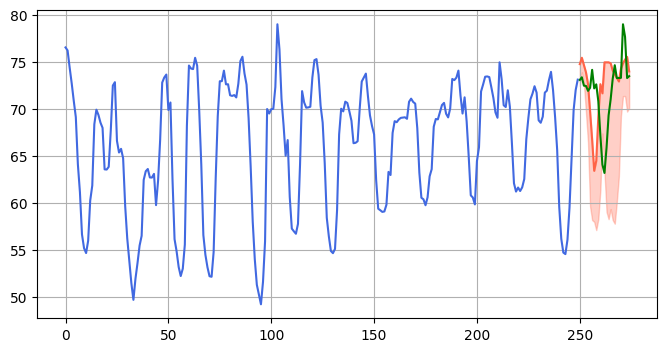

In [ ]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(len(df_energy_past['price actual']), len(df_energy_past.index) + predict_length)
low, median, high = np.quantile(forecast[df_energy.columns.get_loc('price actual')].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(list(df_energy_past['price actual']), color="royalblue", label="historical data")
plt.plot(forecast_index, high, color="tomato", label="median forecast")
plt.plot(forecast_index, list(df_energy_future['price actual'][:predict_length]), color="green", label="ground truth")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()

In [31]:
criterion = torch.nn.MSELoss()
print("MSE Loss: ", criterion(torch.tensor(list(df_energy_future['price actual'][:predict_length])).float(), torch.tensor(high).float()), criterion(torch.tensor([1.0]), torch.tensor([1.0])))

MSE Loss:  tensor(24.2512) tensor(0.)
